In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from itertools import combinations_with_replacement

def ZBL(rij, Zi, Zj):

    const = 1/(4*np.pi*55.26349406e-4)

    a = 0.46850/(Zi**0.23 + Zj**0.23)

    x = rij/a

    phi = 0.18175*np.exp(-3.19980*x) + 0.50986*np.exp(-0.94229*x) + \
          0.28022*np.exp(-0.40290*x) + 0.02817*np.exp(-0.20162*x)
    
    return const*phi*(Zi*Zj/rij)

def LJ(r, epsilon, sigma):
    
    x = sigma/r
    E = 4*epsilon*(x**12 - x**6)
    return E

In [23]:
import os

cwd = os.getcwd()

folder = os.path.dirname(cwd)

folder = folder + '/'

129.91060738371053


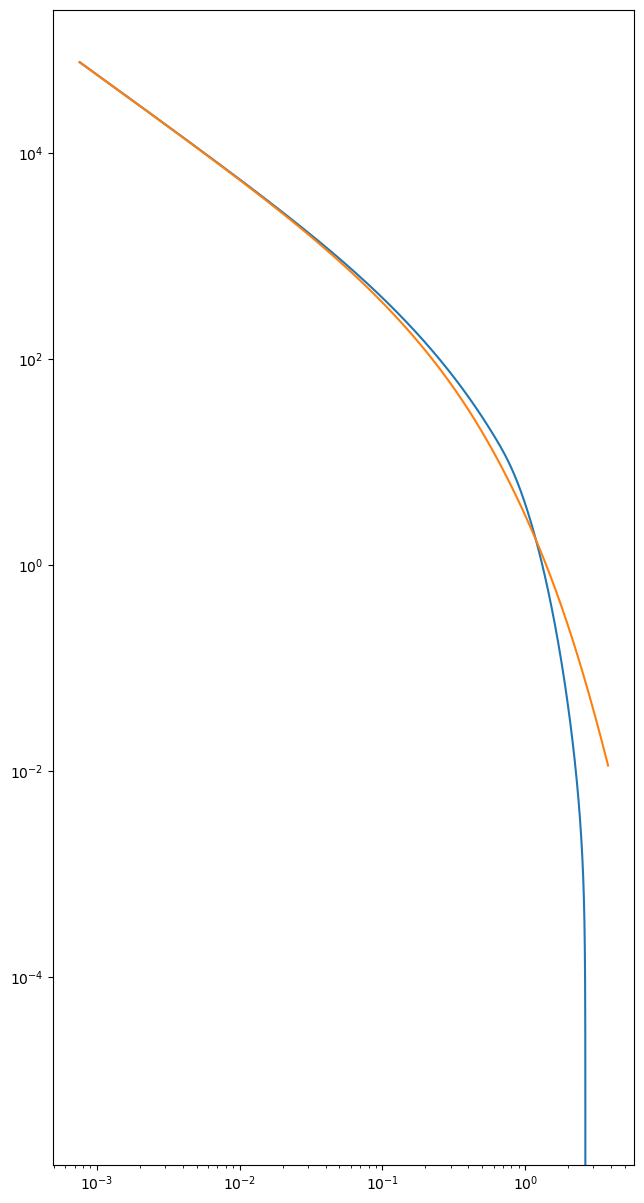

In [24]:
he_he = np.loadtxt('%sPotentials/He-Beck1968_modified.table' % folder,
                   skiprows=7)

plt.loglog(he_he[:,1], he_he[:,2])
plt.loglog(he_he[:,1], ZBL(he_he[:,1], 2, 2))
print(np.mean((he_he[:,2]-ZBL(he_he[:,1], 2, 2))**2))

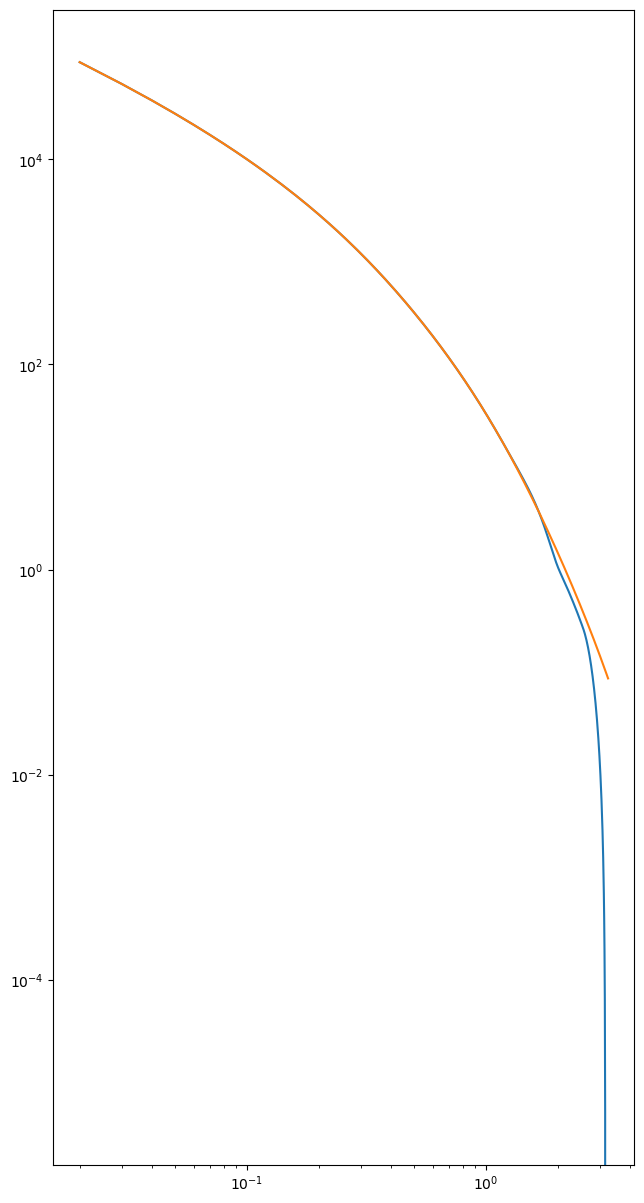

In [25]:
w_he = np.loadtxt('%sPotentials/W-He-Juslin.table' % folder, skiprows=7)

plt.loglog(w_he[:,1], w_he[:,2])
plt.loglog(w_he[:,1], ZBL(w_he[:,1], 74, 2))

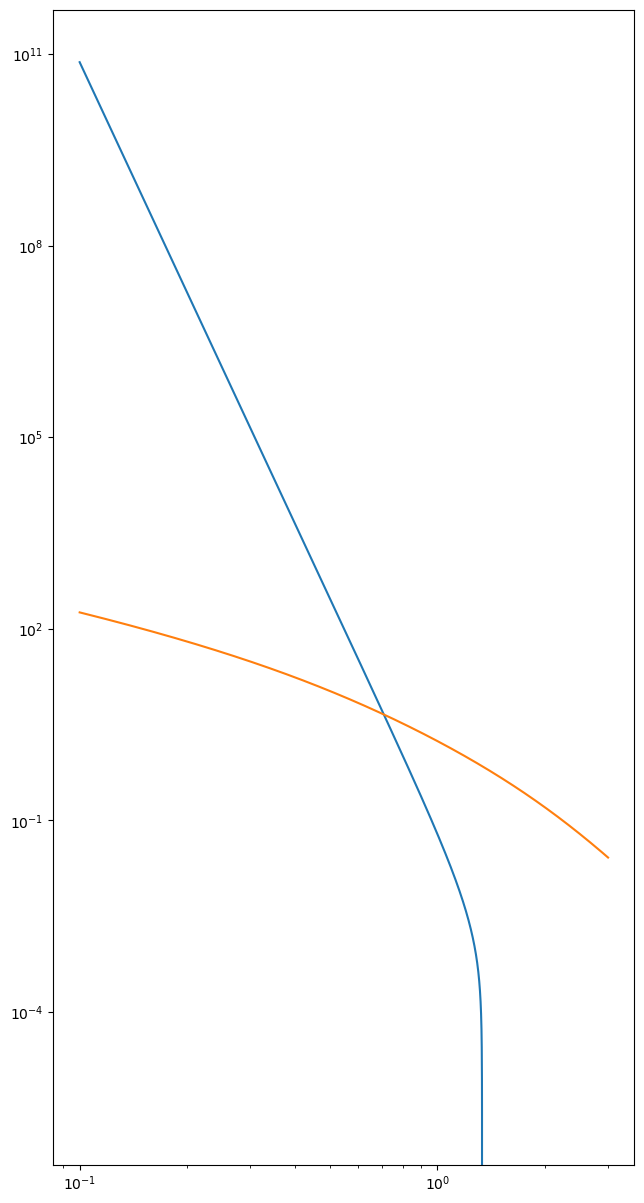

In [26]:
r = np.linspace(0.1, 3,5000)

he_h = LJ(r, 5.9225e-4, 1.333)

plt.plot(r, he_h)
plt.loglog(r, ZBL(r, 2, 1))

[-1.21273117  1.48848648 -5.7767475  -2.73489032  1.64986025  5.97630834] [-1.21273117  1.48848648 -5.7767475  -2.73489032  1.64986025  5.97630834]
[-1.21273117  1.48848648 -5.7767475  -2.73489032  1.64986025  5.97630834] [-1.21273117  1.48848648 -5.7767475  -2.73489032  1.64986025  5.97630834]
[-1.21273117  1.48848648 -5.7767475  -2.73489032  1.64986025  5.97630834] [-1.21273117  1.48848648 -5.7767475  -2.73489032  1.64986025  5.97630834]


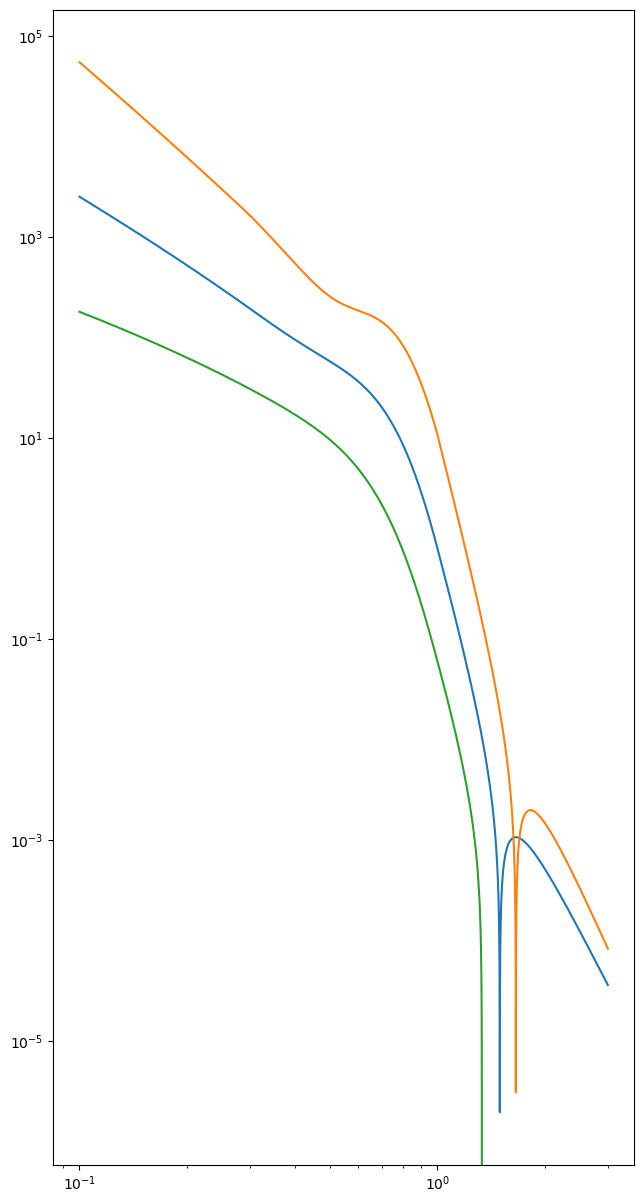

In [27]:

def spline_he_h(r, rz, rl):
    A = np.array([
            
            [rl**i for i in range(6)],
            [rz**i for i in range(6)],
            [i*rl**(i-1) for i in range(6)],
            [i*rz**(i-1) for i in range(6)],
            [np.clip(i*(i-1)*rl**(i-2), a_min = 0, a_max=np.inf) for i in range(6)],
            [np.clip(i*(i-1)*rz**(i-2), a_min = 0, a_max=np.inf) for i in range(6)],
])

    l = np.log10( LJ(rl,5.9225e-4, 1.333) )

    z = np.log10( ZBL(rz, 2, 1) )

    h = 1e-5

    dl = np.log10( LJ(rl + h,5.9225e-4, 1.333) ) - np.log10( LJ(rl - h,5.9225e-4, 1.333) )

    dz = np.log10( ZBL(rz + h, 2, 1) ) - np.log10( ZBL(rz - h, 2, 1) )

    d2l = np.log10( LJ(rl + h,5.9225e-4, 1.333) ) - 2*l + np.log10( LJ(rl - h, 5.9225e-4, 1.333) )

    d2z = np.log10( ZBL(rz + h, 2, 1) ) - 2*z + np.log10( ZBL(rz - h , 2, 1) ) 

    dl = 0.5*dl/h

    dz = 0.5*dz/h

    d2l = d2l/h**2

    d2z = d2z/h**2

    b = np.array([l, z, dl, dz, d2l, d2z])

    a = np.linalg.solve(A,b)
    print(b, A@a)

    E = np.zeros(r.shape)
    for idx, _r in enumerate(r):
        if _r < rz:
            E[idx] = ZBL(_r, 2, 1)
        elif _r > rl:
            E[idx] = LJ(_r,5.9225e-4, 1.333)
        else:
            E[idx] = 10**(a @ np.array([_r**i for i in range(6)]))
    return E, a

rz = 0.3
rl = 1
spline_pot, a = spline_he_h(r, rz, rl)

h = 1e-5
dspline_pot, a = spline_he_h(r+h, rz, rl)

d_spline_pot, a = spline_he_h(r-h, rz, rl)

plt.loglog(r, np.abs((dspline_pot - spline_pot)/h))
plt.loglog(r, np.abs((dspline_pot - 2*spline_pot + d_spline_pot)/(h**2)))
plt.loglog(r, spline_pot)
#plt.plot(r, he_h)
#plt.loglog(r, ZBL(r, 2, 1))

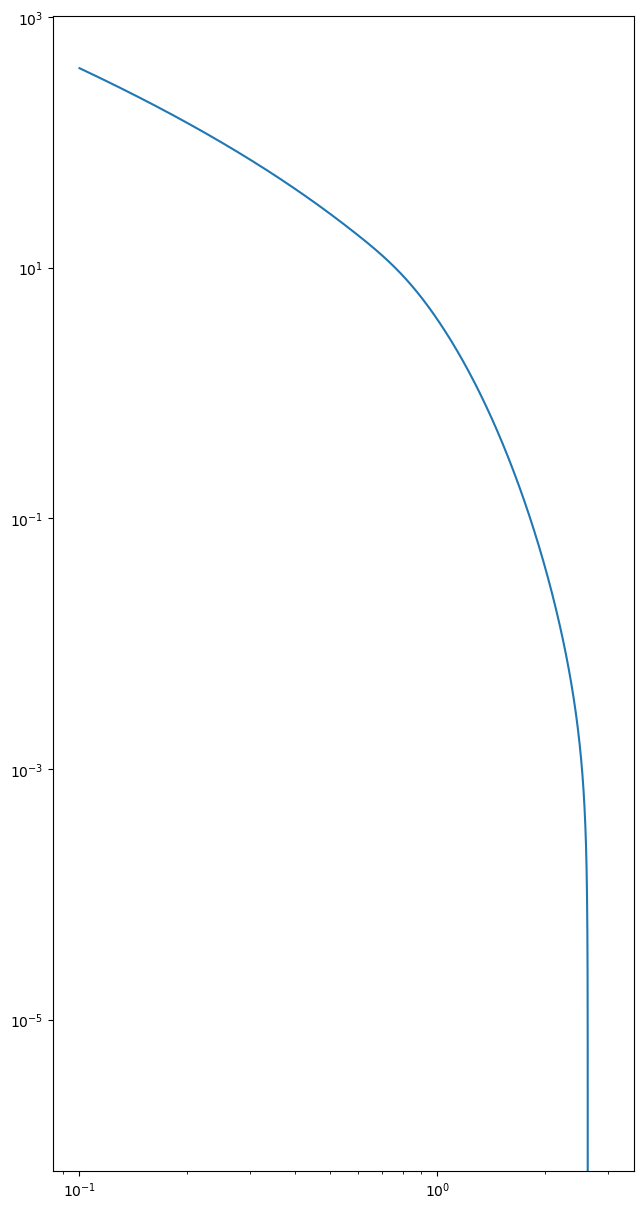

In [28]:
f = interp1d(he_he[:,1], he_he[:,2], kind = 'cubic')

plt.loglog(r, f(r))

In [29]:
def spline_He_He(r):

    data = np.loadtxt('%sPotentials/He-Beck1968_modified.table' % folder,
                      skiprows=7)
    spline = interp1d(data[:,1], data[:,2])
    if r == 0:
        return 0.0
    
    if r < data[:,1].min():
        return ZBL(r, 2, 2)
    elif r > data[:,1].max():
        return 0.0
    else:
        return spline(r)


def spline_W_He(r):

    data = np.loadtxt('%sPotentials/W-He-Juslin.table' % folder, skiprows=7)
    spline = interp1d(data[:,1], data[:,2])

    if r == 0:
        return 0.0
    
    if r < data[:,1].min():
        return ZBL(r, 74, 2)
    elif r > data[:,1].max():
        return 0.0
    else:
        return spline(r)
    
def spline_H_He(r, a):
    
    if r == 0:
        return 0.0
    
    if r < rz:
        return ZBL(r, 2, 1)
        
    elif r > rl:
        return LJ(r,5.9225e-4, 1.333)
    else:
        return 10**(a @ np.array([r**i for i in range(6)]))
    

/Users/cd8607/Documents/Test_Potentials/Jupyter Notebooks
4.8697e+03
4.8840e+01
3.2373e+02
4.3777e+00
1.0839e+01
2.7053e+01


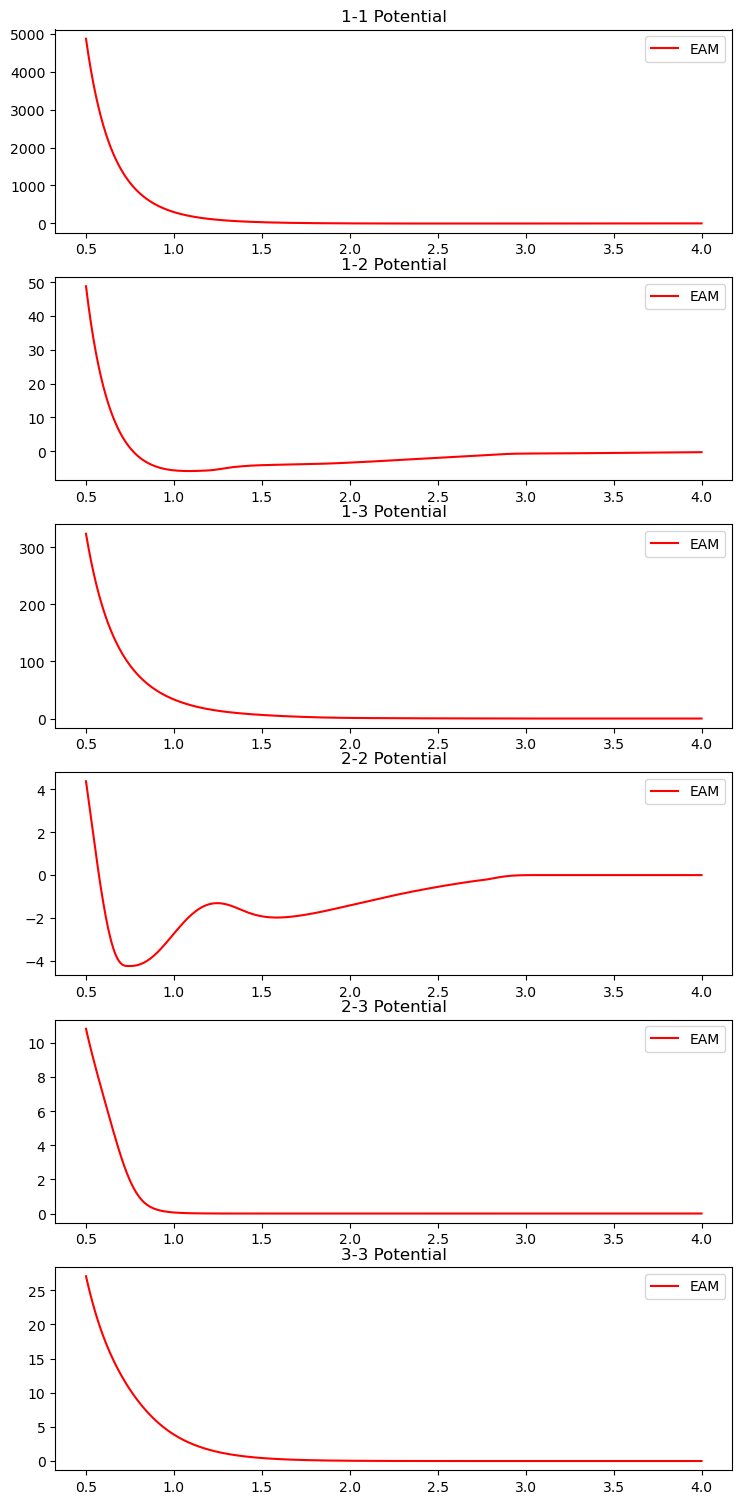

In [32]:
k = 0
print(os.getcwd())
plt.rcParams['figure.figsize'] = [7.5,15]

fig, ax = plt.subplots(6,1)
fig.tight_layout()
error = 0

for [i,j] in combinations_with_replacement([1, 2, 3],2):
    x = np.loadtxt('%sData/Diatomic Plots/Distance.txt' % folder)

    eam = np.loadtxt('%sData/Diatomic Plots/EAM_%d%d.txt' %(folder, i,j))
    overlay = np.loadtxt('%sData/Diatomic Plots/Overlay_%d%d.txt' % (folder, i, j))

    ax[k].plot(x,eam, color=  'r', label = 'EAM')
    #ax[k].loglog(x, overlay, linewidth = 2, label = 'Overlay')
    ax[k].legend()
    ax[k].title.set_text('%d-%d Potential' % (i,j))
    k += 1
    print('%8.4e' % eam.max())

/Users/cd8607/Documents/Test_Potentials/Jupyter Notebooks
0.02188301359592515
0.0002825851810044355
0.13463479155370806
5.965755564929509e-05
293.7243670622055
0.00011767193732836745


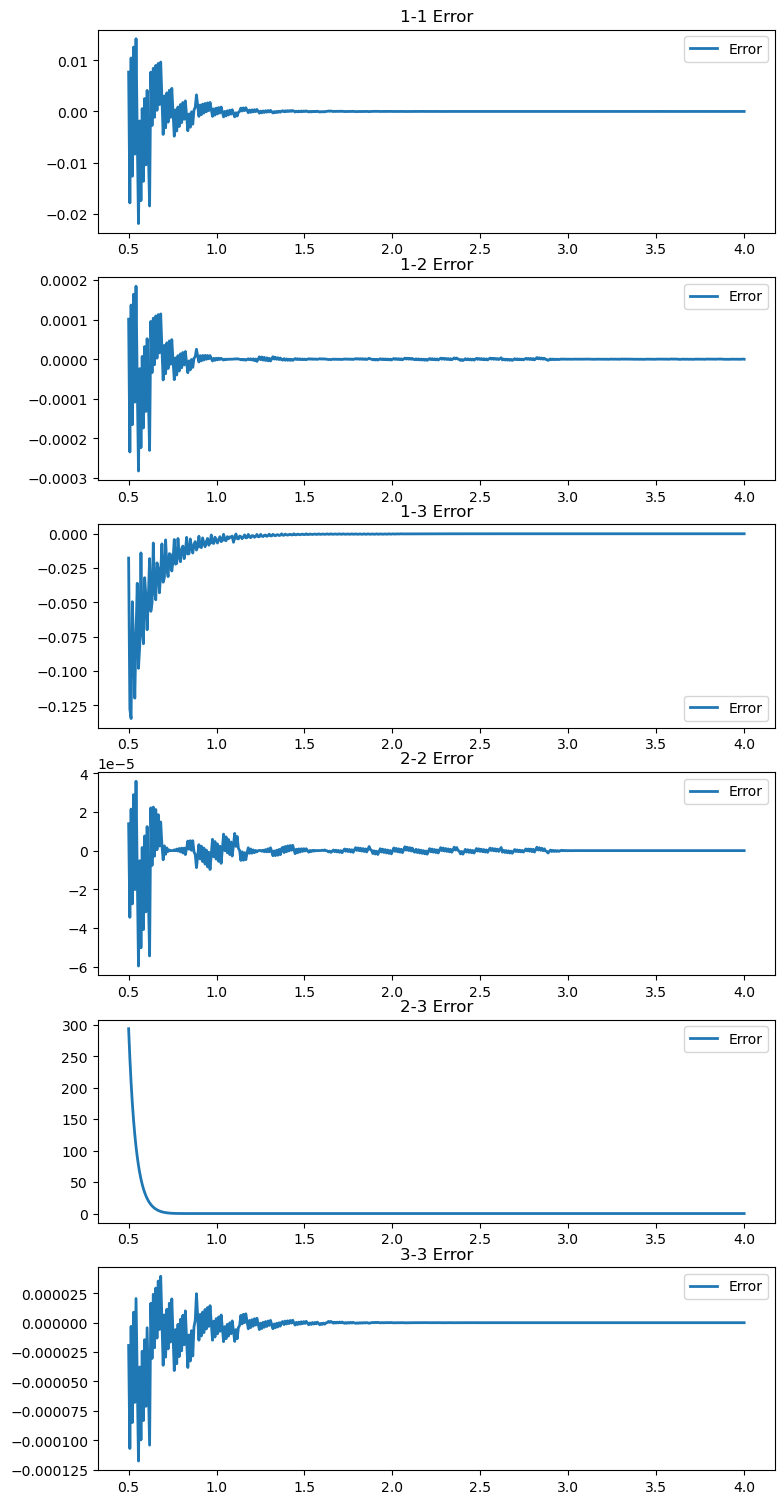

In [31]:
k = 0
print(os.getcwd())
plt.rcParams['figure.figsize'] = [7.5,15]

fig, ax = plt.subplots(6,1)
fig.tight_layout()
error = 0

for [i,j] in combinations_with_replacement([1, 2, 3],2):
    x = np.loadtxt('%sData/Diatomic Plots/Distance.txt' % folder)

    eam = np.loadtxt('%sData/Diatomic Plots/EAM_%d%d.txt' %(folder, i,j))
    overlay = np.loadtxt('%sData/Diatomic Plots/Overlay_%d%d.txt' % (folder, i, j))

    ax[k].plot(x, overlay - eam, linewidth = 2, label = 'Error')
    ax[k].legend()
    ax[k].title.set_text('%d-%d Error' % (i,j))
    print(np.abs(overlay - eam).max())
    k += 1